In [1]:
import torch
import numpy as np
from tqdm import tqdm
from torchvision import transforms, datasets

from CnnGAN import Discriminator, Generator, show_plt, createOnehot2DSeed

In [2]:
device = 'cpu'
# mps에서는 conv_transpose2d 구현되지 않음
# if torch.mps.is_available():
#     device = 'mps'

if torch.cuda.is_available():
    device = 'cuda'

print(device)

cpu


In [3]:
train_dataset = datasets.MNIST(root = "../data/",
                               train = True,
                               transform = transforms.ToTensor())
num_classes = len(train_dataset.classes)

In [4]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = torch.nn.BCELoss()
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
genr_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)

In [5]:
def train_step(model, x, target, criterion, optimizer):
    model.train()
    pred = model(x)
    pred = pred.squeeze(dim=0)
    loss = criterion(pred, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

### 주의사항
 - 모델에 시드 값이 정규분포를 따를때 생성기의 학습이 잘됨 -> 그냥 랜덤값이면 학습 안됨
 - 모델 만들때, Normalizer, Activation 함수가 어떤것이냐에 따라 차이를 많이 보임
   - 현재 코드에서는 LayerNormalizer, LeakliyRelu 가 가장 빠르게 모드 붕괴를 해소함

  0%|          | 0/4 [00:00<?, ?it/s, 1/60000, dis_loss: 0.7127, gen_loss: 0.9095]

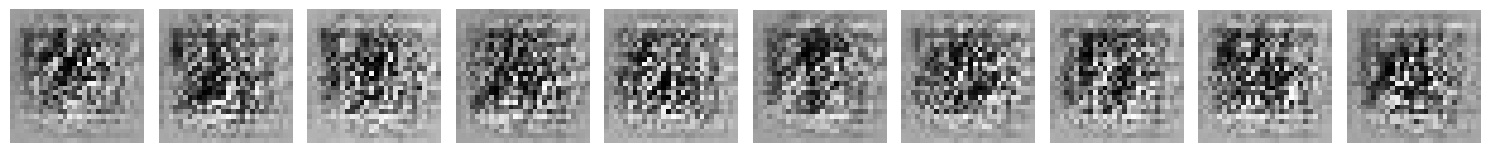

  0%|          | 0/4 [00:20<?, ?it/s, 1001/60000, dis_loss: 0.0249, gen_loss: 9.2444]

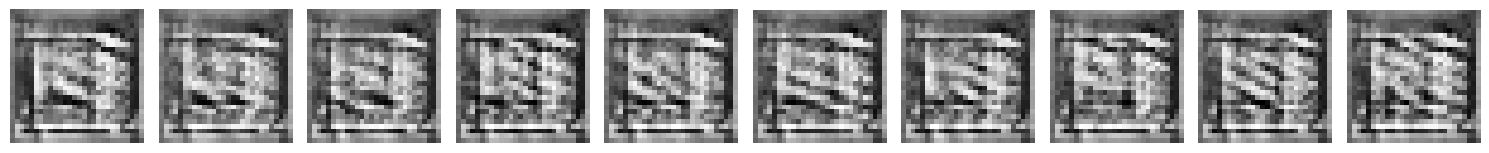

  0%|          | 0/4 [00:41<?, ?it/s, 2001/60000, dis_loss: 0.0148, gen_loss: 10.7879]

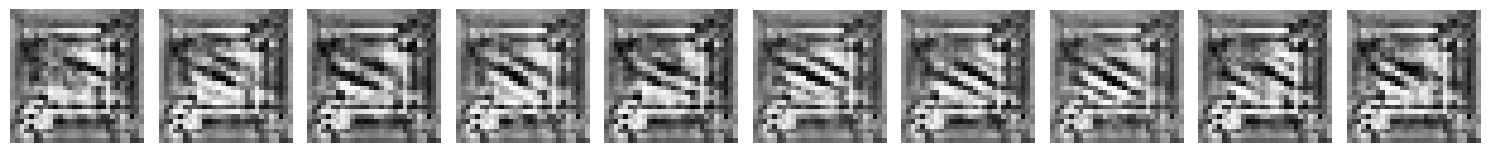

  0%|          | 0/4 [01:03<?, ?it/s, 3001/60000, dis_loss: 0.0148, gen_loss: 10.5685]

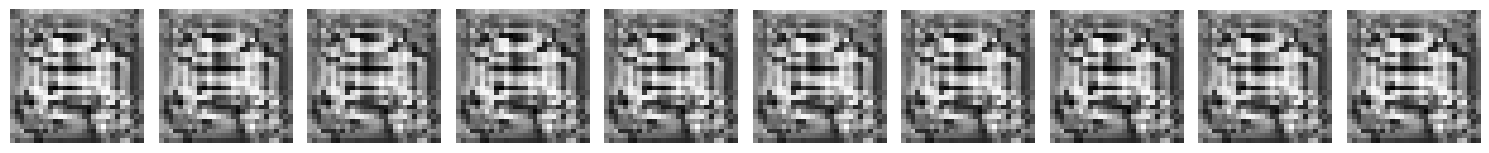

  0%|          | 0/4 [01:24<?, ?it/s, 4001/60000, dis_loss: 0.0136, gen_loss: 10.3462]

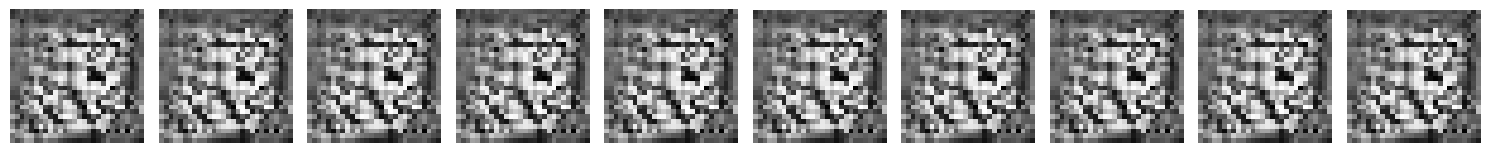

  0%|          | 0/4 [01:38<?, ?it/s, 4588/60000, dis_loss: 0.0119, gen_loss: 10.3152]


KeyboardInterrupt: 

In [6]:
progress = tqdm(range(4))
for epoch in progress:
    dis_losses = []
    gen_losses = []
    
    for step, (x, label) in enumerate(train_dataset):
        # one_hot = torch.nn.functional.one_hot(torch.tensor(label), 10).type(torch.FloatTensor).to(device)
        x = x.reshape(1, *x.shape).to(device)
        # x = torch.concat([x, one_hot], dim=0)
        target = torch.Tensor([1.]).to(device)
        pos_loss = train_step(discriminator, x, target, criterion, disc_optimizer)

        seed = createOnehot2DSeed([label], num_classes)
        x = generator(seed).detach()
        # x = x.reshape(-1).to(device)
        # x = torch.concat([x, one_hot], dim=0)
        target = torch.Tensor([0.]).to(device)
        neg_loss = train_step(discriminator, x, target, criterion, disc_optimizer)

        seed = createOnehot2DSeed([label], num_classes)
        x = generator(seed)
        # x = x.reshape(-1).to(device)
        # x = torch.concat([x, one_hot], dim=0)
        target = torch.Tensor([1.]).to(device)
        gen_loss = train_step(discriminator, x, target, criterion, genr_optimizer)

        dis_losses.append(pos_loss)
        dis_losses.append(neg_loss)
        gen_losses.append(gen_loss)

        progress.set_postfix_str(f"{step + 1}/{len(train_dataset)}, dis_loss: {np.mean(dis_losses):.04f}, gen_loss: {np.mean(gen_losses):.04f}")
        if step % 1000 == 0:
            show_plt(generator, num_classes)

generator.eval()
show_plt(generator, 10)

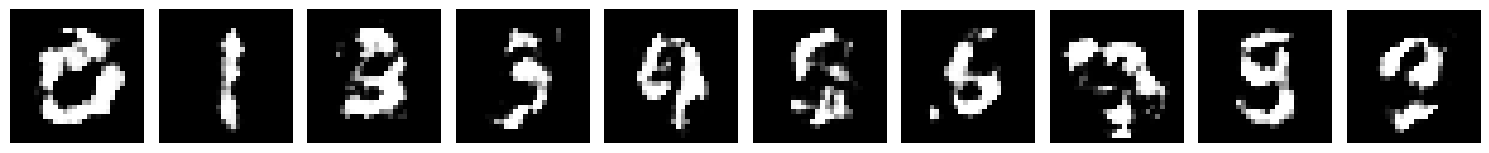

In [24]:
generator.eval()
show_plt(generator, 10)